In [29]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from keras.models import Model 
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
from keras.layers import Lambda

In [30]:
def system_dynamics(x_t, u_t):
    """
    System dynamics: x_t+1 = x_t + 0.5*u_t
    """
    return x_t + 0.5 * u_t

def reward_fn(x, u):
    return x**2 + 0.001 * u**2
# Training settings
epochs = 1000
history = []
n_steps = 10
gamma = 1.0
np.random.seed(42)

In [31]:
# Actor
actor_input = Input(shape=(1,))
# x = Dense(16, activation='relu')(actor_input)
raw_out = Dense(1, activation='linear')(actor_input)
actor_model = Model(inputs=actor_input, outputs=raw_out)

# Critic
critic_input = Input(shape=(2,))
x = Dense(16, activation='relu')(critic_input)
critic_output = Dense(1, activation='linear')(x)
critic_model = Model(inputs=critic_input, outputs=critic_output)

critic_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
for epoch in range(epochs):
    x_t = np.random.uniform(-10, 10)
    total_reward = 0

    for step in range(n_steps):
        x_tensor = tf.convert_to_tensor([[x_t]], dtype=tf.float32)

        # Select action (with exploration)
        u_t = actor_model(x_tensor).numpy()[0, 0] + np.random.normal(0, 1)
        u_t = np.clip(u_t, -5, 5)

        # Apply action and observe transition
        x_next = system_dynamics(x_t, u_t)
        r_t = reward_fn(x_t, u_t)

        # ----- Critic update -----
        with tf.GradientTape() as tape_critic:
            q_pred = critic_model(tf.convert_to_tensor([[x_t, u_t]], dtype=tf.float32))
            u_next = actor_model(tf.convert_to_tensor([[x_next]], dtype=tf.float32))
            q_next = critic_model(tf.concat([[[x_next]], u_next], axis=1))
            q_target = r_t + gamma * q_next
            critic_loss = tf.reduce_mean((q_pred - q_target) ** 2)

        critic_grads = tape_critic.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grads, critic_model.trainable_variables))

        # ----- Actor update -----
        with tf.GradientTape() as tape_actor:
            u_pred = actor_model(tf.convert_to_tensor([[x_t]], dtype=tf.float32))
            q_val = critic_model(tf.concat([[[x_t]], u_pred], axis=1))
            actor_loss = tf.reduce_mean(q_val)

        actor_grads = tape_actor.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grads, actor_model.trainable_variables))

        x_t = x_next
        total_reward += r_t

        history.append(total_reward)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Total Reward: {total_reward:.2f}, Critic Loss: {critic_loss.numpy():.4f}, Actor Loss: {actor_loss.numpy():.4f}")

Epoch 10, Total Reward: 45.33, Critic Loss: 1.3287, Actor Loss: -0.5206
Epoch 20, Total Reward: 26.32, Critic Loss: 0.3681, Actor Loss: -0.4570
Epoch 30, Total Reward: 62.91, Critic Loss: 0.0017, Actor Loss: -0.0331
Epoch 40, Total Reward: 12.54, Critic Loss: 1.4340, Actor Loss: -0.2260
Epoch 50, Total Reward: 142.47, Critic Loss: 0.6887, Actor Loss: -0.1535
Epoch 60, Total Reward: 6.55, Critic Loss: 0.0000, Actor Loss: -0.0175
Epoch 70, Total Reward: 42.86, Critic Loss: 0.0419, Actor Loss: 0.1100
Epoch 80, Total Reward: 123.14, Critic Loss: 0.0947, Actor Loss: 0.1146
Epoch 90, Total Reward: 3.98, Critic Loss: 0.0827, Actor Loss: -0.0299
Epoch 100, Total Reward: 96.88, Critic Loss: 0.0023, Actor Loss: 0.0787
Epoch 110, Total Reward: 6.13, Critic Loss: 0.0430, Actor Loss: 0.2257
Epoch 120, Total Reward: 36.42, Critic Loss: 0.0036, Actor Loss: -0.0837
Epoch 130, Total Reward: 34.01, Critic Loss: 0.0048, Actor Loss: 0.1080
Epoch 140, Total Reward: 3.31, Critic Loss: 0.6994, Actor Loss: 0.

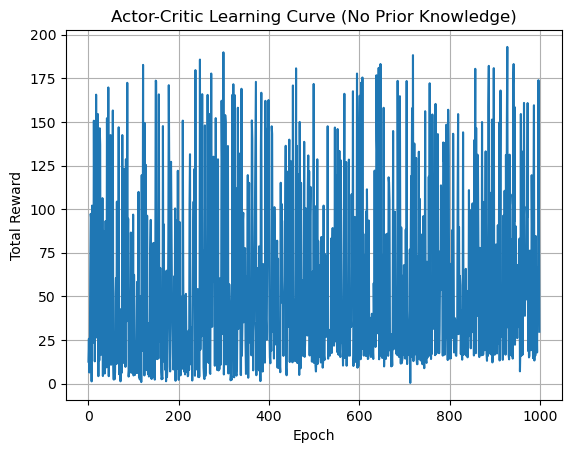

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


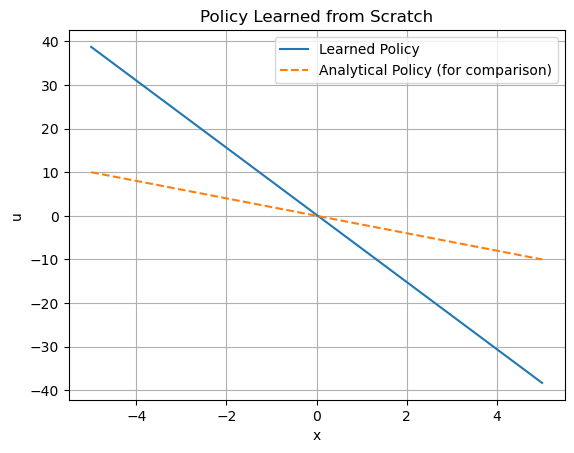

In [34]:
# ----- Plot learning curve -----
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.grid()
plt.title("Actor-Critic Learning Curve (No Prior Knowledge)")
plt.show()

# ----- Visualize learned policy -----
x_test = np.linspace(-5, 5, 100).reshape(-1, 1).astype(np.float32)
u_pred = actor_model.predict(x_test)
plt.plot(x_test, u_pred, label='Learned Policy')
plt.plot(x_test, -2 * x_test, '--', label='Analytical Policy (for comparison)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.title("Policy Learned from Scratch")
plt.show()